In [2]:
import numpy as np
import pandas as pd
import os
import torchvision
import torch
from PIL import Image
import cv2
from torchvision import models, transforms
from torch.nn import functional
from torch.autograd import Variable
from sklearn.cluster import KMeans

# Load Data

In [4]:
df=pd.read_pickle("./df.pkl")
top5=set(df.top1.unique()).union(set(df.top2.unique())).union(set(df.top3.unique())).union(set(df.top4.unique())).union(set(df.top5.unique()))
top3=set(df.top1.unique()).union(set(df.top2.unique())).union(set(df.top3.unique()))
top1=set(df.top1.unique())

import requests
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
classes = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

top1class=list(set([classes[x].split(',')[0].split()[0] for x in list(top1) ]))

In [5]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin",binary=True)
inst=pd.DataFrame([model[x] for x in top1class if x in model])
inst.index=[x for x in top1class if x in model]

C:\Users\zjw\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [14]:
inst

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
tiger,-0.068359,0.182617,-0.177734,0.166016,0.146484,0.025391,0.050049,-0.035156,0.253906,0.002228,...,-0.105469,-0.050537,0.146484,-0.026245,0.090332,0.039551,0.029419,0.190430,-0.102051,0.172852
shovel,0.214844,0.063965,0.143555,0.228516,-0.180664,-0.034180,0.228516,0.023804,0.197266,-0.068359,...,-0.094727,-0.026489,-0.255859,0.310547,-0.095703,-0.046631,-0.257812,-0.000763,-0.269531,0.001328
cloak,0.466797,0.271484,-0.144531,-0.027954,-0.363281,0.023926,0.398438,0.025269,0.146484,0.396484,...,-0.047852,0.249023,-0.071777,0.138672,-0.206055,-0.332031,0.324219,0.190430,0.088867,0.449219
tobacco,0.122070,-0.138672,-0.097656,0.408203,0.255859,-0.111328,0.022705,0.145508,-0.047852,0.066895,...,-0.380859,-0.216797,0.330078,-0.188477,-0.158203,0.053955,0.251953,0.373047,0.349609,0.126953
barber,0.052002,0.031738,0.085938,-0.082520,-0.010864,0.406250,-0.233398,-0.082031,-0.022583,0.186523,...,0.156250,0.110352,-0.210938,0.125000,0.223633,0.251953,-0.063965,0.221680,0.145508,0.060303
coho,0.052979,0.097656,-0.458984,0.105957,0.168945,-0.200195,-0.523438,0.128906,0.208008,0.470703,...,0.215820,-0.137695,-0.084961,-0.249023,0.092773,-0.204102,-0.128906,-0.221680,0.734375,0.105957
vault,-0.174805,0.417969,-0.076172,0.013184,0.183594,-0.012207,-0.023560,0.045166,0.378906,-0.066895,...,-0.020874,0.154297,-0.345703,-0.031494,0.017822,-0.263672,-0.057617,-0.117188,0.140625,-0.034912
sarong,0.204102,0.056152,-0.129883,0.320312,-0.123535,-0.224609,-0.031738,-0.402344,-0.246094,0.285156,...,-0.194336,0.400391,0.173828,0.135742,-0.087402,0.098145,0.021851,-0.206055,-0.267578,0.679688
promontory,0.140625,-0.081055,0.128906,0.098145,0.091797,-0.232422,0.091309,-0.419922,0.472656,0.110840,...,0.048584,0.141602,-0.402344,0.144531,0.036133,0.021729,-0.124023,-0.020264,0.189453,0.174805
American,0.007751,0.164062,0.185547,0.320312,-0.130859,-0.059326,0.103027,0.092773,0.093262,-0.065918,...,0.008484,-0.166992,-0.263672,0.067871,-0.054199,-0.027588,0.089355,0.217773,0.206055,-0.059570


# Dendrogram

In [36]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    plt.figure(figsize=(15,10))
    ddata = dendrogram(*args, **kwargs)
    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

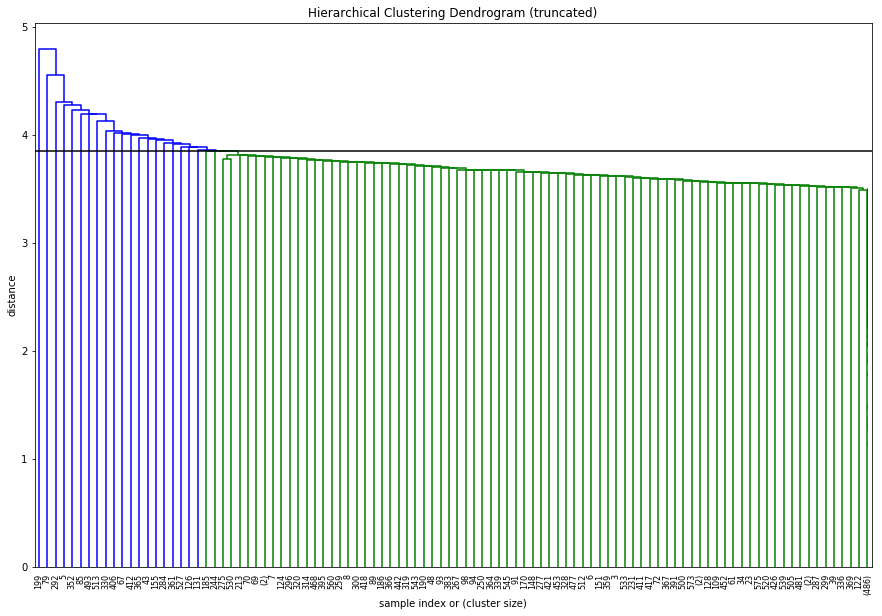

In [66]:
from scipy.cluster.hierarchy import linkage, dendrogram, ward
linkage_matrix = linkage(inst,"single")
linked_array = ward(linkage_matrix)

fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=100,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,
    annotate_above=10,
    max_d=3.85
)

plt.show();

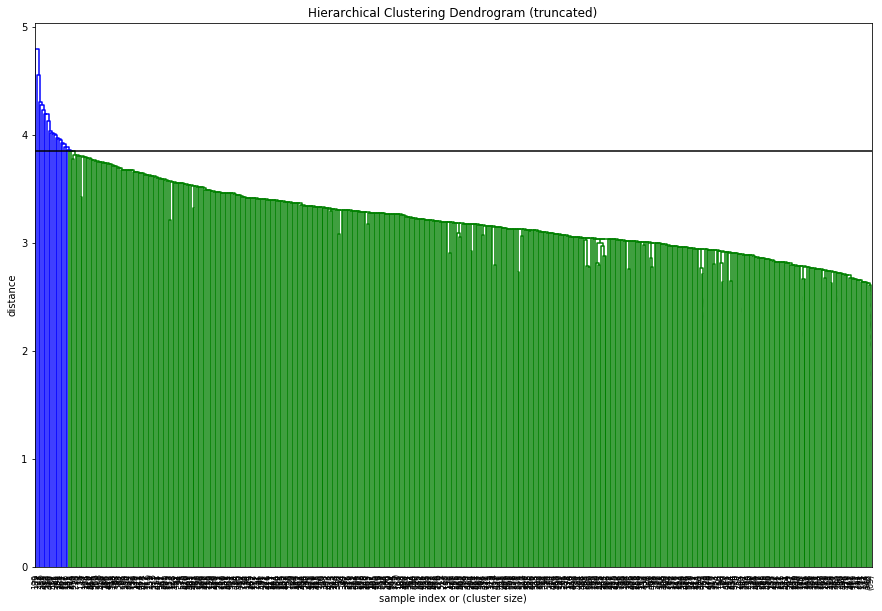

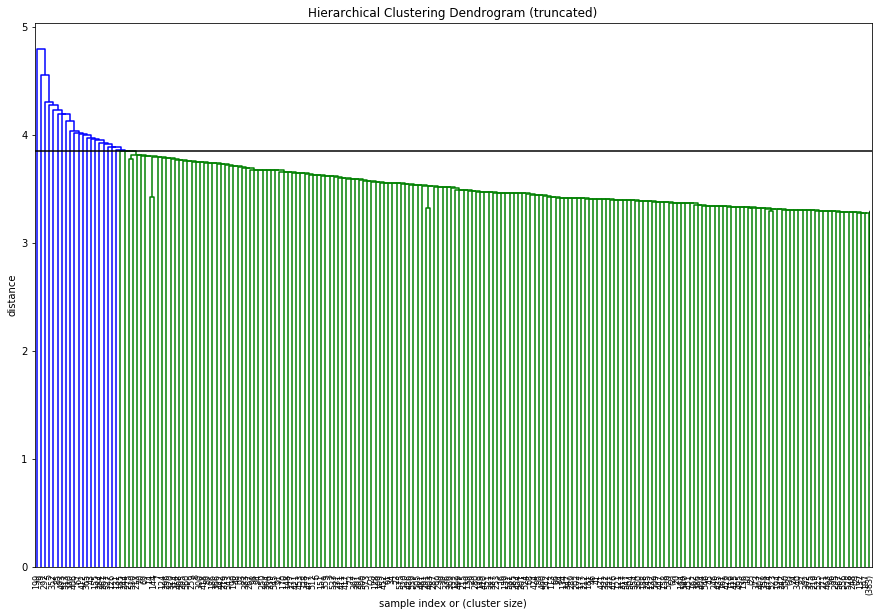

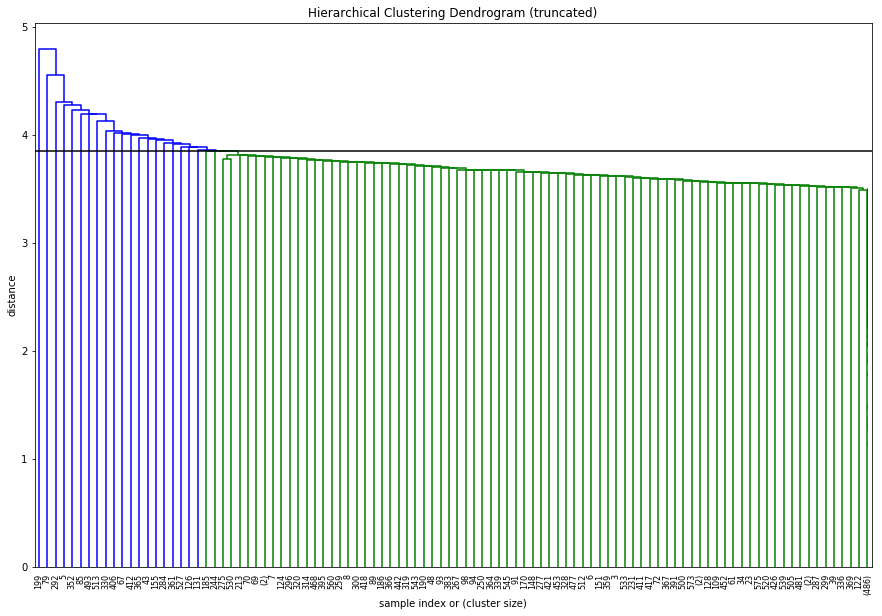

In [77]:
plt.figure()

# 1
fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=500,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,
    annotate_above=10,
    max_d=3.85
);
plt.show();

# 2
fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=200,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,
    annotate_above=10,
    max_d=3.85
);
plt.show();

# 3
fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=100,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,
    annotate_above=10,
    max_d=3.85
);
plt.show();